
# VGG 16 pre-trained model for U-TAD 2024 Task recognition cats and dogs

## 1. Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tensorflow import data as tf_data
import keras

seed = 1
keras.utils.set_random_seed(seed)


## 2. Read in the training data

Here you set the image size, an essential parameter for the rest of the modelling



In [2]:
image_size = (224, 224)

# when working with 20_000 files for training this
# will lead to exactly 160 mini-batches per epoch
batch_size = 125

# https://keras.io/api/data_loading/image/#imagedatasetfromdirectory-function

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    #"PetImages",
    "/kaggle/input/u-tad-dogs-vs-cats-2024/train/train",
    validation_split=0.2,
    subset="both",
    seed=seed,
    image_size=image_size,
    batch_size=batch_size,
    labels="inferred",
    label_mode="categorical",
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Using 5000 files for validation.



## 3. Load the VGG16 pre trained model

We explore this pre-trained model by asking for its summary. It is just another model, as any one we could write ourselves, but already specified -and trained!


In [3]:
vgg = keras.applications.VGG16(weights=None, include_top=True, input_shape=(224, 224, 3))
vgg.load_weights('/kaggle/input/vgg16weights/vgg16_weights_tf_dim_ordering_tf_kernels.h5')
# Congelar las capas de VGG16 para que no se entrenen de nuevo
for layer in vgg.layers:
    layer.trainable = False


## 4. Set the non-trainable layers and the last -or classification- layer specific for this problem

Note we keep the original VGG-16 initial -input- layer. Thus, we need to setup the image size -as we did before


In [ ]:
from keras.applications import VGG16
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten  

# Cargar el modelo VGG16 pre-entrenado
vgg = VGG16(weights='/kaggle/input/vgg16weights/vgg16_weights_tf_dim_ordering_tf_kernels.h5', include_top=True)

# Conectar una capa de Flatten y capas adicionales al final
inp = vgg.input
x = vgg.layers[-2].output  # Usamos la salida de la penúltima capa
x = Flatten(name="new_flatten")(x)

# Capas adicionales
x = Dense(256, activation='relu', name="dense_256")(x)
x = Dropout(0.5, name="dropout_1")(x)
x = Dense(128, activation='relu', name="dense_128")(x)
x = Dropout(0.5, name="dropout_2")(x)

# Capa de salida
out = Dense(2, activation='softmax', name="output")(x)

# Crear el modelo final con las capas adicionales
model_new = Model(inputs=inp, outputs=out)

In [5]:


# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True


model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ new_flatten (Flatten)           │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_256 (Dense)               │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             

 Total params: 135,342,530 (516.29 MB)

 Trainable params: 258 (1.01 KB)

 Non-trainable params: 135,342,272 (516.29 MB)

## 5. Train (fit)

In [6]:
epochs = 3

history = model_new.fit(train_ds,
                    validation_data = val_ds,
                    epochs = epochs)

Epoch 1/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 5950s 37s/step - accuracy: 0.5847 - loss: 1.3461 - val_accuracy: 0.8986 - val_loss: 0.2829
Epoch 2/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 5974s 37s/step - accuracy: 0.7639 - loss: 0.5447 - val_accuracy: 0.9058 - val_loss: 0.2772
Epoch 3/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 5944s 37s/step - accuracy: 0.8092 - loss: 0.4229 - val_accuracy: 0.9034 - val_loss: 0.2877


## 6. Visualization of the training

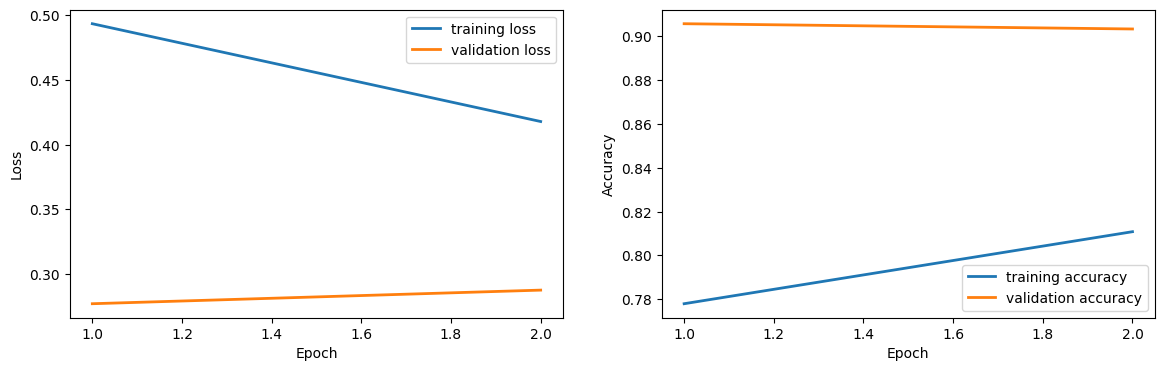

In [7]:
logs = pd.DataFrame(history.history)

plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.plot(logs.loc[1:,"loss"], lw=2, label='training loss')
plt.plot(logs.loc[1:,"val_loss"], lw=2, label='validation loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(logs.loc[1:,"accuracy"], lw=2, label='training accuracy')
plt.plot(logs.loc[1:,"val_accuracy"], lw=2, label='validation accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='lower right')
plt.show()


## 7. Create predictions for all test images

In [8]:
folder_path = "/kaggle/input/u-tad-dogs-vs-cats-2024/test/test"

In [ ]:
import os  
import pandas as pd
import keras

folder_path = "/kaggle/input/u-tad-dogs-vs-cats-2024/test/test"


image_size = (224, 224)  

discrimination_threshold = 0.5  
predictions_dict = {}

for img in os.listdir(folder_path):
    img_path = os.path.join(folder_path, img)
    
    # save the image name
    file_name = img.split('/')[-1]
    file_no_extension = file_name.split('.')[0]
    
    img = keras.utils.load_img(img_path, target_size=image_size)
    img_array = keras.utils.img_to_array(img)
    img_array = keras.ops.expand_dims(img_array, 0)
    
    predictions = model_new.predict(img_array, verbose=None)
    score = predictions[0][1]
    label = int(score > discrimination_threshold)  

    # save the predictions to a dictionary
    predictions_dict[int(file_no_extension)] = label

# Convierte las predicciones en un DataFrame de pandas
predictions_df = pd.DataFrame(predictions_dict.items(), columns=["id", "label"])

# Ordena el DataFrame por el ID de la imagen
predictions_df = predictions_df.sort_values(by='id', ascending=True)

# Guarda las predicciones en un archivo CSV
predictions_df.to_csv('predictions.csv', index=False)

print("Predicciones guardadas en predictions.csv")


Predicciones guardadas en predictions.csv


## 8. Save predictions to a competition submission file

In [10]:
submission = pd.DataFrame(predictions_dict.items(), columns=["id", "label"]).sort_values(by='id', ascending=True)
submission.to_csv('submission.csv',index=False)

# print numbers of each class label
submission["label"].value_counts()

label
0    675
1    392
Name: count, dtype: int64

In [11]:
submission

,id,label
292,1,0
1031,2,1
863,3,0
830,4,0
78,5,0
...,...,...
712,1063,1
525,1064,0
951,1065,1
470,1066,1


**Submit by clicking on the Submit button at the right**